In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import geopandas as gpd

In [4]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [5]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [6]:
new_data.crs = {'init':'epsg:4326'}


### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [7]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")
new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)

In [8]:
new_data['logBiomass'] = np.log(new_data.plotBiomass)
new_data['logSppN'] = np.log(new_data.SppN)

In [9]:
## Let´s make a simple linear trend here.
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [10]:
## All data
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)

model = smf.ols(formula='logBiomass ~ logSppN',data=new_data)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4757.
Date:                Thu, 23 Nov 2017   Prob (F-statistic):               0.00
Time:                        19:27:58   Log-Likelihood:                -36670.
No. Observations:               36845   AIC:                         7.334e+04
Df Residuals:                   36843   BIC:                         7.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4882      0.009    976.347      0.000         8.471     8.505
logSppN        0.3740      0.005     68.974      0.000         0.363     0.385
==============================================================================
Omnibus:                     1627.980   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2356.149
Skew:                          -0.421   Prob(JB):                         0.00
Kurtosis:                       3.908   Cond. No.                         5.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
new_data['residuals1'] = results.resid

## Subseting the data

Three different methods for subsetting the data.
1. Using a systematic selection by index modulus
2. Using a random uniform selection by indices.
2. A geographic subselection (Clip)

### Systematic selection

In [12]:
def systSelection(n,k):
    idxs = range(0,n,k)
    systematic_sample = new_data.iloc[idxs]
    return systematic_sample
##################
n = len(new_data)
k = 10 # The k-th element to take as a sample

In [13]:
systematic_sample = systSelection(n,k)

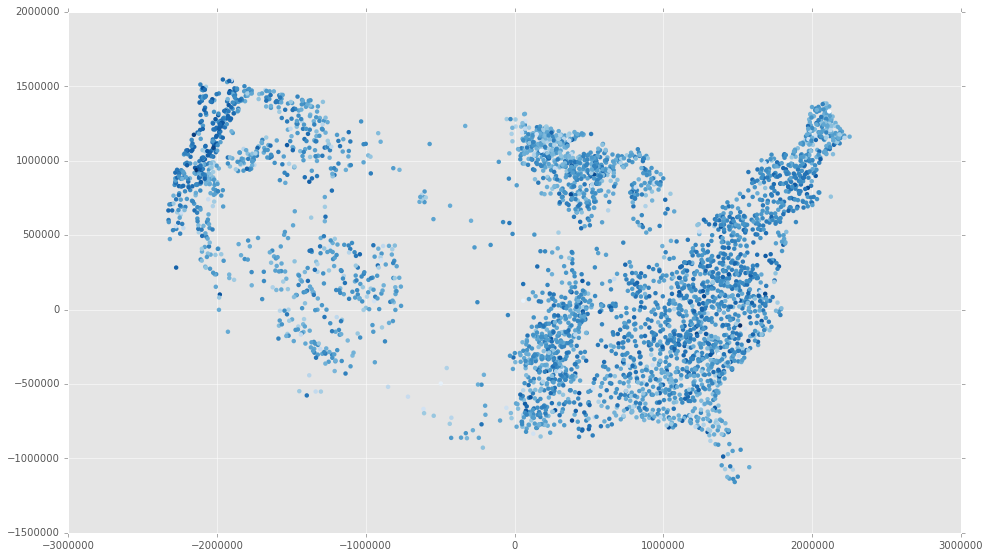

In [14]:
ax= systematic_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 

### Random (Uniform) selection


In [15]:
def randomSelection(n,p):
    idxs = np.random.choice(n,p,replace=True)
    random_sample = new_data.iloc[idxs]
    return random_sample
#################
n = len(new_data)
p = 3000 # The amount of samples taken (let's do it without replacement)

In [16]:
random_sample = randomSelection(n,p)

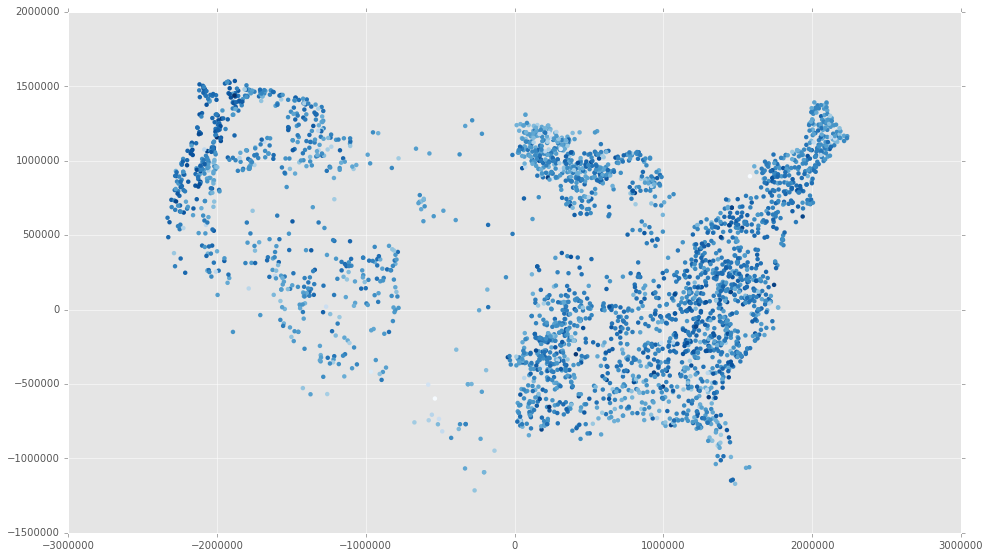

In [17]:
ax= random_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 


### Geographic subselection

In [18]:
def subselectDataFrameByCoordinates(dataframe,namecolumnx,namecolumny,minx,maxx,miny,maxy):
    """
    Returns a subselection by coordinates using the dataframe/
    """
    minx = float(minx)
    maxx = float(maxx)
    miny = float(miny)
    maxy = float(maxy)
    section = dataframe[lambda x:  (x[namecolumnx] > minx) & (x[namecolumnx] < maxx) & (x[namecolumny] > miny) & (x[namecolumny] < maxy) ]
    return section

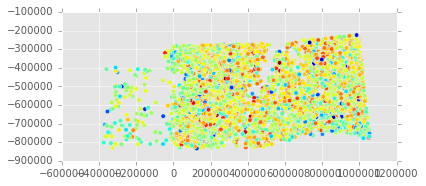

In [19]:
# COnsider the the following subregion
minx = -100
maxx = -85
miny = 30
maxy = 35

section = subselectDataFrameByCoordinates(new_data,'LON','LAT',minx,maxx,miny,maxy)

#section = new_data[lambda x:  (x.LON > minx) & (x.LON < maxx) & (x.LAT > miny) & (x.LAT < maxy) ]
section.plot(column='logBiomass')



## Model Analysis with the empirical variogram


In [20]:
from external_plugins.spystats import tools

#### Global Variogram
Calculated previously. Here I want to check if by taking some of these subsamples is possible to capture the spatial structure.

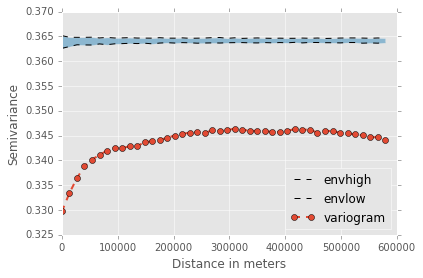

In [21]:
thrs_dist = 600000
nt = 30 # num iterations
filename = "../HEC_runs/results/low_q/data_envelope.csv"
envelope_data = pd.read_csv(filename)
gvg = tools.Variogram(new_data,'logBiomass',using_distance_threshold=thrs_dist)
gvg.envelope = envelope_data
gvg.empirical = gvg.envelope.variogram
gvg.lags = gvg.envelope.lags
vdata = gvg.envelope.dropna()
gvg.plot(refresh=False,legend=False)


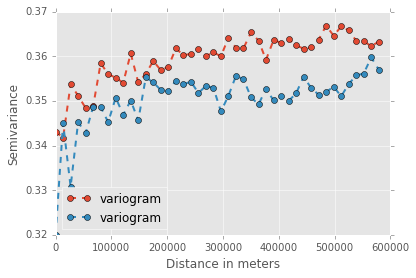

In [22]:
## For systematic sample
systematic_variogram = tools.Variogram(systematic_sample,'logBiomass',using_distance_threshold=thrs_dist)
sysemp = systematic_variogram.calculateEmpirical()
#systematic_variogram.calculateEnvelope(num_iterations=nt)
systematic_variogram.plot(with_envelope=False)
#syst = systematic_variogram.envelope[['lags','empirical']]
## For random sample
random_variogram = tools.Variogram(random_sample,'logBiomass',using_distance_threshold=thrs_dist)
random_variogram.plot(with_envelope=False)
#random_variogram.calculateEnvelope(num_iterations=nt)
#randemp = random_variogram.calculateEmpirical()
#rand = random_variogram.envelope[['lags','empirical']]
## For geographic sample
geographic_variogram = tools.Variogram(section,'logBiomass',using_distance_threshold=thrs_dist)
#geographic_variogram.calculateEnvelope(num_iterations=nt)
geoemp = geographic_variogram.calculateEmpirical()
#geog = geographic_variogram.envelope[['lags','empirical']]

In [23]:
## For systematic sample
systsamps = map(lambda k : systSelection(n,k), range(5,30))
vgs = map(lambda sample : tools.Variogram(sample,'logBiomass',using_distance_threshold=thrs_dist),systsamps)
emps = map(lambda vg : vg.calculateEmpirical(),vgs)

In [24]:
d = pd.concat([vgs[0].lags,pd.DataFrame(emps).transpose()],axis=1)


In [ ]:
d.variogram.plot(x=d.lags.values,legend=False)
gvg.plot(refresh=False,legend=False)

In [ ]:
d.plot()

In [ ]:
systematic_variogram = tools.Variogram(systematic_sample,'logBiomass',using_distance_threshold=thrs_dist)
sysemp = systematic_variogram.calculateEmpirical()
#systematic_variogram.calculateEnvelope(num_iterations=nt)
systematic_variogram.plot(with_envelope=False)
#syst = systematic_variogram.envelope[['lags','empirical']]
## For random sample
random_variogram = tools.Variogram(random_sample,'logBiomass',using_distance_threshold=thrs_dist)
random_variogram.plot(with_envelope=False)
#random_variogram.calculateEnvelope(num_iterations=nt)
#randemp = random_variogram.calculateEmpirical()
#rand = random_variogram.envelope[['lags','empirical']]
## For geographic sample
geographic_variogram = tools.Variogram(section,'logBiomass',using_distance_threshold=thrs_dist)
#geographic_variogram.calculateEnvelope(num_iterations=nt)
geoemp = geographic_variogram.calculateEmpirical()
#geog = geographic_variogram.envelope[['lags','empirical']]

## Fitting the empirical variogram to into a theoretical model

In [ ]:

from scipy.optimize import curve_fit
s = 0.345
r = 100000.0
nugget = 0.33
init_vals = [0.34, 50000, 0.33]     # for [amp, cen, wid]
best_vals_gaussian, covar_gaussian = curve_fit(exponentialVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
#best_vals_gaussian, covar_gaussian = curve_fit(exponentialVariogram, xdata=vdata.lags, ydata=vdata.variogram, p0=init_vals)
#best_vals_gaussian, covar_gaussian = curve_fit(sphericalVariogram, xdata=vdata.lags, ydata=vdata.variogram, p0=init_vals)
v

In [ ]:
gaussianVariogram(hx)

In [ ]:
s =best_vals[0]
r = best_vals[1]
nugget = best_vals[2]
fitted_gaussianVariogram = lambda x : exponentialVariogram(x,sill=s,range_a=r,nugget=nugget)
gammas = pd.DataFrame(map(fitted_gaussianVariogram,hx))
import functools
fitted_gaussian2 = functools.partial(gaussianVariogram,s,r,nugget)

In [ ]:
hx = np.linspace(0,600000,100)
vg = tools.Variogram(section,'residuals1',using_distance_threshold=500000)
## already fitted previously
s = 0.345255240992
r = 65857.797111
nugget = 0.332850902482

# Valid parametric empirical variogram
That, covariance matrix always postive semi-definite.
## Gaussian Model
$$\gamma (h)=(s-n)\left(1-\exp \left(-{\frac  {h^{2}}{r^{2}a}}\right)\right)+n1_{{(0,\infty )}}(h)$$

In [ ]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    Ih = 1.0 if h >= 0 else 0.0    
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget*Ih
    return g_h

## Exponential Model
$$\gamma (h)=(s-n)(1-\exp(-h/(ra)))+n1_{{(0,\infty )}}(h)$$

In [ ]:
def exponentialVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.array):
        Ih = [1.0 if hx >= 0.0 else 0.0 for hx in h]
    else:
        Ih = 1.0 if h >= 0 else 0.0
    g_h = (sill - nugget)*(1 - np.exp(-h/range_a)) + (nugget*Ih)
    return g_h

In [ ]:
h = 2
[1.0 if hx >= 0.0 else 0.0 for hx in i

## Spherical Variogram
$$\gamma (h)=(s-n)\left(\left({\frac  {3h}{2r}}-{\frac  {h^{3}}{2r^{3}}}\right)1_{{(0,r)}}(h)+1_{{[r,\infty )}}(h)\right)+n1_{{(0,\infty )}}(h))$$

In [ ]:
def sphericalVariogram(h,sill=0,range_a=0,nugget=0):
    Ih = 1.0 if h >= 0 else 0.0
    I0r = 1.0 if h <= range_a else 0.0
    Irinf = 1.0 if h > range_a else 0.0
    g_h = (sill - nugget)((3*h / float(2*range_a))*I0r + Irinf) - (h**3 / float(2*range_a)) + (nugget*Ih)
    return g_h

In [ ]:
def theoreticalVariogram(model_function,sill,range_a,nugget):
    return lambda x : model_function(x,sill,range_a,nugget)

In [ ]:
tvariogram = theoreticalVariogram(gaussianVariogram,s,r,nugget)
tvariogram = theoreticalVariogram(,s,r,nugget)



In [ ]:
%time gs = np.array(map(tvariogram,hx))

In [ ]:
x = vg.plot(with_envelope=True,num_iterations=30,refresh=False)
plt.plot(hx,gs,color='blue')


In [ ]:
import statsmodels.regression.linear_model as lm

In [ ]:
Mdist = vg.distance_coordinates.flatten()
%time vars = np.array(map(tvariogram,Mdist))

In [ ]:
CovMat = vars.reshape(len(section),len(section))
X = section.logSppN.values
Y = section.logBiomass.values


In [ ]:
plt.imshow(CovMat)

In [ ]:
%time model = lm.GLS(Y,X,sigma=CovMat)

In [ ]:
%time results = model.fit()

## Residuals of $ Biomass ~ SppRich + Z(x,y) + \epsilon $
Using all data

